In [2]:
#import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.colors as colors
from matplotlib import rc
plt.rcParams["font.serif"]       = 'Times New Roman'
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.minor.size"] = 5
plt.rcParams["xtick.labelsize"]  = 25
plt.rcParams["ytick.labelsize"]  = 25

plt.rcParams["legend.title_fontsize"]=25
import sys

In [3]:
class PerfTime:
    def __init__(self, num_gpu, num_cells, allgatherv, recursion, copy_XY_local, copy_cpu2gpu, gpu_pFor, copy_gpu2cpu, 
                 total_exclude, total_include):
        self.num_gpu = num_gpu
        self.num_cells = num_cells
        self.allgatherv = allgatherv
        self.recursion = recursion
        self.copy_XY_local = copy_XY_local
        self.copy_cpu2gpu = copy_cpu2gpu
        self.gpu_pFor = gpu_pFor
        self.copy_gpu2cpu = copy_gpu2cpu
        self.total_exclude = total_exclude
        self.total_include = total_include


#cpu_recursion, cpu_other, gpu_pFor, gpu_other these times are divided by total time.

#        def myfunc(self):
#            print("Hello my name is " + self.name)

In [53]:
perf = []
perf.append(PerfTime(8,     8000,   0.000672566, 0.000209454, 5.4134e-05, 0.000924531, 7.043e-06,       0.006092248, 0.001867728, 0.007959976))
perf.append(PerfTime(64,     64000, 0.001580052, 0.001639256, 6.2551e-05, 0.004166598, 7.735e-06,       0.048335201, 0.007456192, 0.055791393 ))
perf.append(PerfTime(512,   512000, 0.018721964, 0.018949163, 6.3612e-05, 0.022048375, 8.296000001e-06, 0.390650499, 0.05979141, 0.450441909))
perf.append(PerfTime(1024, 1024000, 1.333961667, 0.039387708, 6.5437e-05, 0.042848164, 7.475e-06,       0.798833725, 1.416270451, 2.215104176 ))



In [54]:
nGPUs_lst=[]
for i in range(0, len(perf)):
    nGPUs_lst.append(perf[i].num_gpu)
nGPUs = np.asarray(nGPUs_lst)
print(nGPUs)

[   8   64  512 1024]


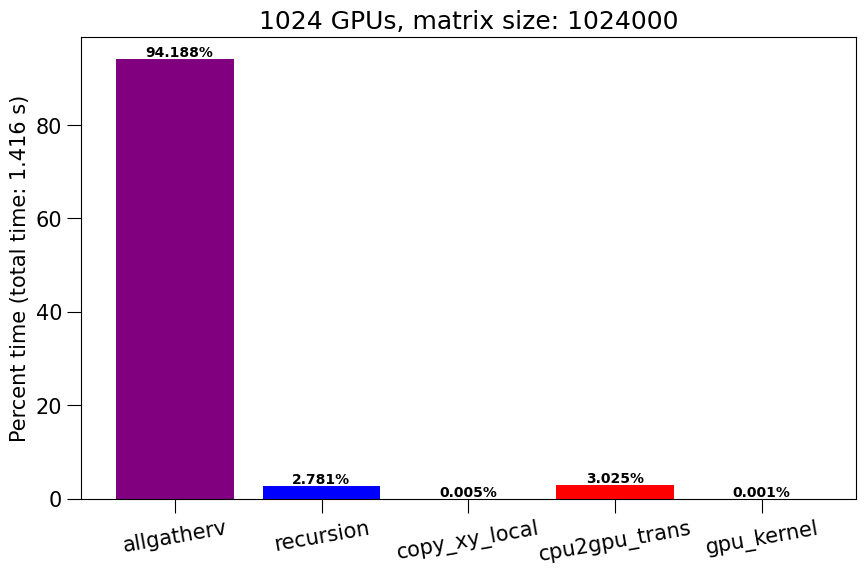

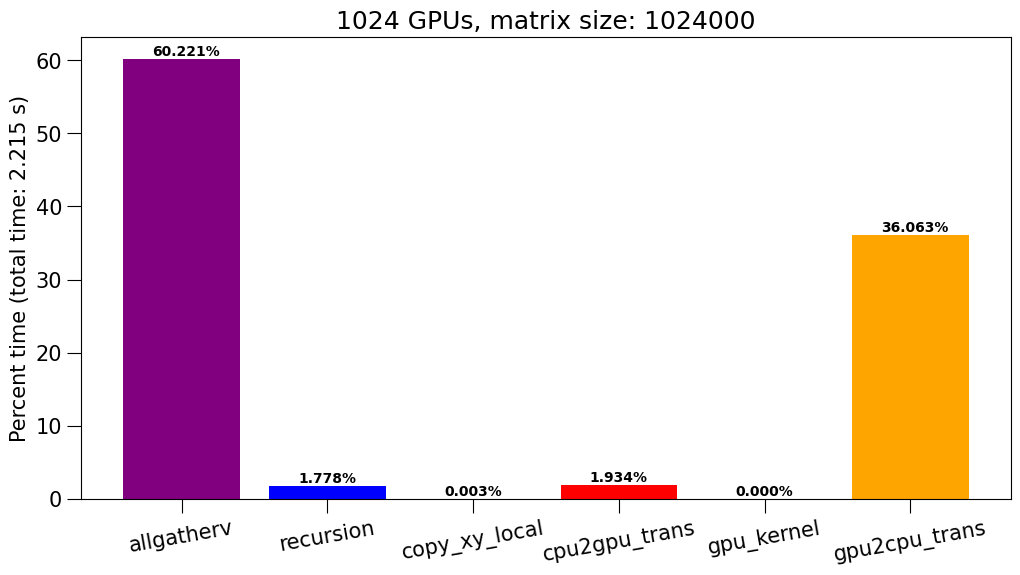

In [55]:
index = 3 #8 GPUs

total_exclude = perf[index].total_exclude
percent_time_exclude = [perf[index].allgatherv/total_exclude,
                        perf[index].recursion/total_exclude,
                        perf[index].copy_XY_local/total_exclude,
                        perf[index].copy_cpu2gpu/total_exclude,
                        perf[index].gpu_pFor/total_exclude]
percent_time_exclude = np.asarray(percent_time_exclude)

fig, ax = plt.subplots()
fig.set_size_inches(10,6)

n_GPUs_str = ['allgatherv','recursion', 'copy_xy_local', 'cpu2gpu_trans', 'gpu_kernel']

colors = ['purple', 'blue',  'teal', 'red', 'green']
ax.bar(n_GPUs_str,percent_time_exclude*100, color=colors)
ax.set_title('%d GPUs, matrix size: %d'%(perf[index].num_gpu,perf[index].num_cells), fontsize=18)
#ax.set_yscale('log')
plt.xticks(rotation=10)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlabel('Country', fontsize=10)
ax.set_ylabel('Percent time (total time: %.3f s)'%(perf[index].total_exclude), fontsize=15)
for i, v in enumerate(percent_time_exclude*100):
    ax.text(i-0.2, v+0.5, "%.3f%%"%(v),
            color = 'k', fontweight = 'bold')
#plt.grid(True)
plt.savefig('Chart_%d_gpu_exclude.png'%(perf[index].num_gpu), bbox_inches = "tight")#


total_include = perf[index].total_include

percent_time_include = [perf[index].allgatherv/total_include,
                        perf[index].recursion/total_include,
                        perf[index].copy_XY_local/total_include,
                        perf[index].copy_cpu2gpu/total_include,
                        perf[index].gpu_pFor/total_include,
                        perf[index].copy_gpu2cpu/total_include]
percent_time_include = np.asarray(percent_time_include)

fig, ax = plt.subplots()
fig.set_size_inches(12,6)

n_GPUs_str = ['allgatherv','recursion', 'copy_xy_local', 'cpu2gpu_trans', 'gpu_kernel', 'gpu2cpu_trans']

colors = ['purple', 'blue',  'teal', 'red', 'green', 'orange']
ax.bar(n_GPUs_str,percent_time_include*100, color=colors)
ax.set_title('%d GPUs, matrix size: %d'%(perf[index].num_gpu,perf[index].num_cells), fontsize=18)

#ax.set_yscale('log')
plt.xticks(rotation=10)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlabel('Country', fontsize=10)
ax.set_ylabel('Percent time (total time: %.3f s)'%(perf[index].total_include), fontsize=15)
for i, v in enumerate(percent_time_include*100):
    ax.text(i-0.2, v+0.5, "%.3f%%"%(v),
            color = 'k', fontweight = 'bold')
#plt.grid(True)
plt.savefig('Chart_%d_gpu_include.png'%(perf[index].num_gpu), bbox_inches = "tight")#

In [45]:
percent_time_include = [perf[index].allgatherv/total_include,
                        perf[index].recursion/total_include,
                        perf[index].copy_XY_local/total_include,
                        perf[index].copy_cpu2gpu/total_include,
                        perf[index].gpu_pFor/total_include,
                        perf[index].copy_gpu2cpu/total_include]

In [38]:
wse_gpu_lst=[]
wse_cpugpu_lst=[]

baseline_gpu_time = (perf[0].copy_cpu2gpu+perf[0].gpu_pFor)
baseline_total_time = perf[0].total_exclude

for i in range(0, len(perf)):
    ngpu_ratio = perf[i].num_gpu/perf[0].num_gpu

    current_gpu_time = (perf[i].copy_cpu2gpu+perf[i].gpu_pFor)   
    wse_gpu = (baseline_gpu_time*ngpu_ratio)/(current_gpu_time)
    wse_gpu_lst.append(wse_gpu)
    
    current_total_time = perf[i].total_exclude
    wse_total = (baseline_total_time*ngpu_ratio)/(current_total_time)
    wse_cpugpu_lst.append(wse_total)
    
wse_gpu = np.asarray(wse_gpu_lst)
wse_cpugpu = np.asarray(wse_cpugpu_lst)

print(wse_gpu)
print(wse_cpugpu)

[1.         1.7853372  2.70307047 2.78239865]
[1.         2.0039484  1.9991934  0.16880193]


/tmp/ipykernel_19447/3802642807.py:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,1200)


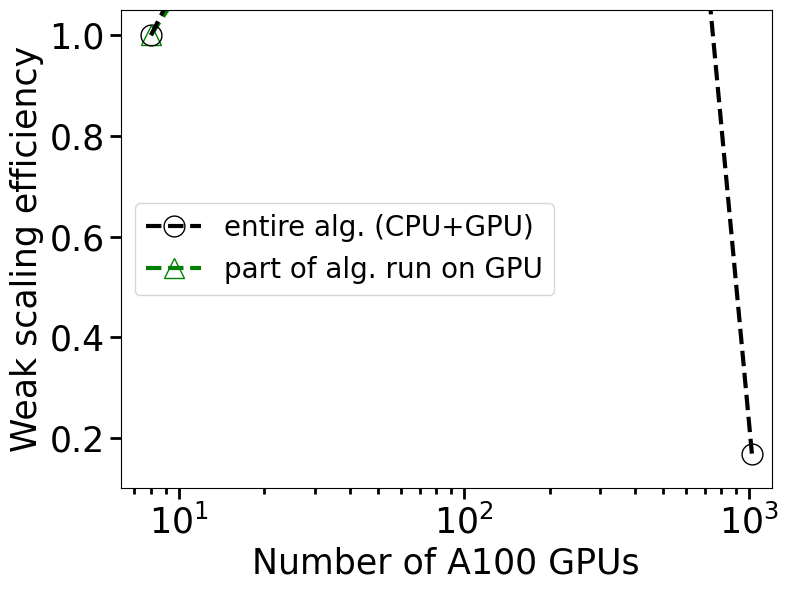

In [39]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
fig.patch.set_facecolor('white')
p2 = ax.plot(nGPUs, wse_gpu,'g--', linewidth=3,marker='^',markersize=15,fillstyle='none', label='part of alg. run on GPU')
p1 = ax.plot(nGPUs, wse_cpugpu,'k--', linewidth=3,marker='o',markersize=15,fillstyle='none', label='entire alg. (CPU+GPU)')
ax.set_xscale('log')

ax.set_xlim(0,1200)
ax.set_ylim(0.1,1.05)

ax.set_ylabel(r'Weak scaling efficiency', fontsize=25)
ax.set_xlabel(r'Number of A100 GPUs', fontsize=25)

#ax2 = ax.twinx() 
#ax2.set_ylim(0,40)
#ax2.set_ylabel(r'Number of cells (billion)', fontsize=25)
#p2=ax2.plot(nGPUs, ncells,'r-.', linewidth=3,marker='^',markersize=15,fillstyle='none',label='number of cells')

lns = p1+p2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center left',prop={'size': 20})

ax.tick_params(which='minor', width=2, length=4, color='k')
ax.tick_params(which='major', width=2, length=8, color='k')
#ax2.tick_params(which='minor', width=2, length=4, color='k')
#ax2.tick_params(which='major', width=2, length=8, color='k')
#ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

fig.tight_layout()
plt.savefig('WSE_MatInv.png', bbox_inches = "tight")#